In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tools.rsa import compute_similarity
from models.admm import ADMM
from utils.helpers import median_matrix_split, best_pairwise_match, zero_matrix_split
from utils.plotting import plot_images_from_embedding
import seaborn as sns
import pandas as pd
from pathlib import Path
def plot_rank_selection(df_full, df_pos, df_neg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    # Plot full dataframes with variance across repeats
    sns.lineplot(data=df_full, x="rank", y="rmse", ax=ax1, errorbar="sd")
    ax1.set_title("Full RSM")
    ax1.axvline(
        x=df_full.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_pos, x="rank", y="rmse", ax=ax2, errorbar="sd")
    ax2.set_title("Positive")
    ax2.axvline(
        x=df_pos.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_neg, x="rank", y="rmse", ax=ax3, errorbar="sd")
    ax3.set_title("Negative")
    ax3.axvline(
        x=df_neg.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )


    plt.tight_layout()
    plt.show()

    # Calculate best ranks using mean RMSE
    rank_pos = df_pos.groupby("rank")["rmse"].mean().idxmin()
    rank_neg = df_neg.groupby("rank")["rmse"].mean().idxmin()
    rank_all = df_full.groupby("rank")["rmse"].mean().idxmin()

    print(f"best rank for positive matrix: {rank_pos}")
    print(f"best rank for negative matrix: {rank_neg}")
    print(f"best rank for all matrix: {rank_all}")

/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df

n_samples  true_rank  max_outer  max_inner  rho  trial_id  best_rank  \
0          100          5          5         10  1.0         0          4   
1          100          5          5         10  1.0         1          5   
2          100          5          5         10  1.0         2          5   
3          100          5          5         10  1.0         3          5   
4          100          5          5         10  1.0         4          5   
..         ...        ...        ...        ...  ...       ...        ...   
475        400         10         10        100  2.0         5         10   
476        400         10         10        100  2.0         6         10   
477        400         10         10        100  2.0         7         10   
478        400         10         10        100  2.0         8         10   
479        400         10         10        100  2.0         9         10   

     best_score  rank_correct  rank_error  seed  
0      0.001986         False           1     0  
1      0.001107          True           0     1  
2      0.001270          True           0     2  
3      0.001068          True           0     3  
4      0.001487          True           0     4  
..          ...           ...         ...   ...  
475    0.001650          True           0   475  
476    0.001694          True           0   476  
477    0.001705          True           0   477  
478    0.001739          True           0   478  
479    0.001838          True           0   479  

[480 rows x 11 columns]

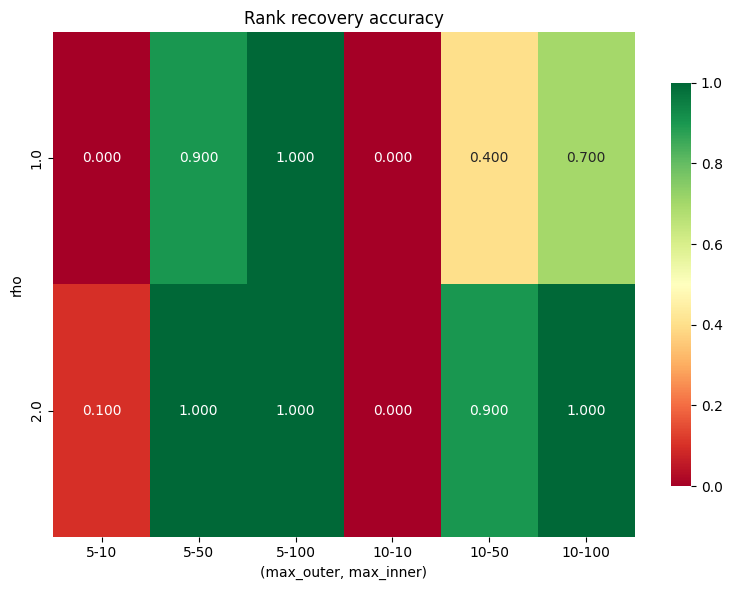

In [4]:
df = pd.read_csv("../results/rank_recovery_results.csv")

five = df[(df["true_rank"] == 5) & (df["n_samples"] == 400)]

# Create heatmap of rank recovery accuracy for all parameter combinations
pivot_data = five.pivot_table(
    values="rank_correct",
    index="rho",
    columns=["max_outer", "max_inner"],
    aggfunc="mean",
)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    pivot_data,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    ax=ax,
    cbar_kws={"shrink": 0.8},
)
ax.set_title("Rank recovery accuracy")
ax.set_xlabel("(max_outer, max_inner)")
ax.set_ylabel("rho")

plt.tight_layout()
plt.show()

### Below we check if there is a power law or somethig similar between the nuber of objects and the optimal training ratio

<Figure size 1920x1440 with 0 Axes>

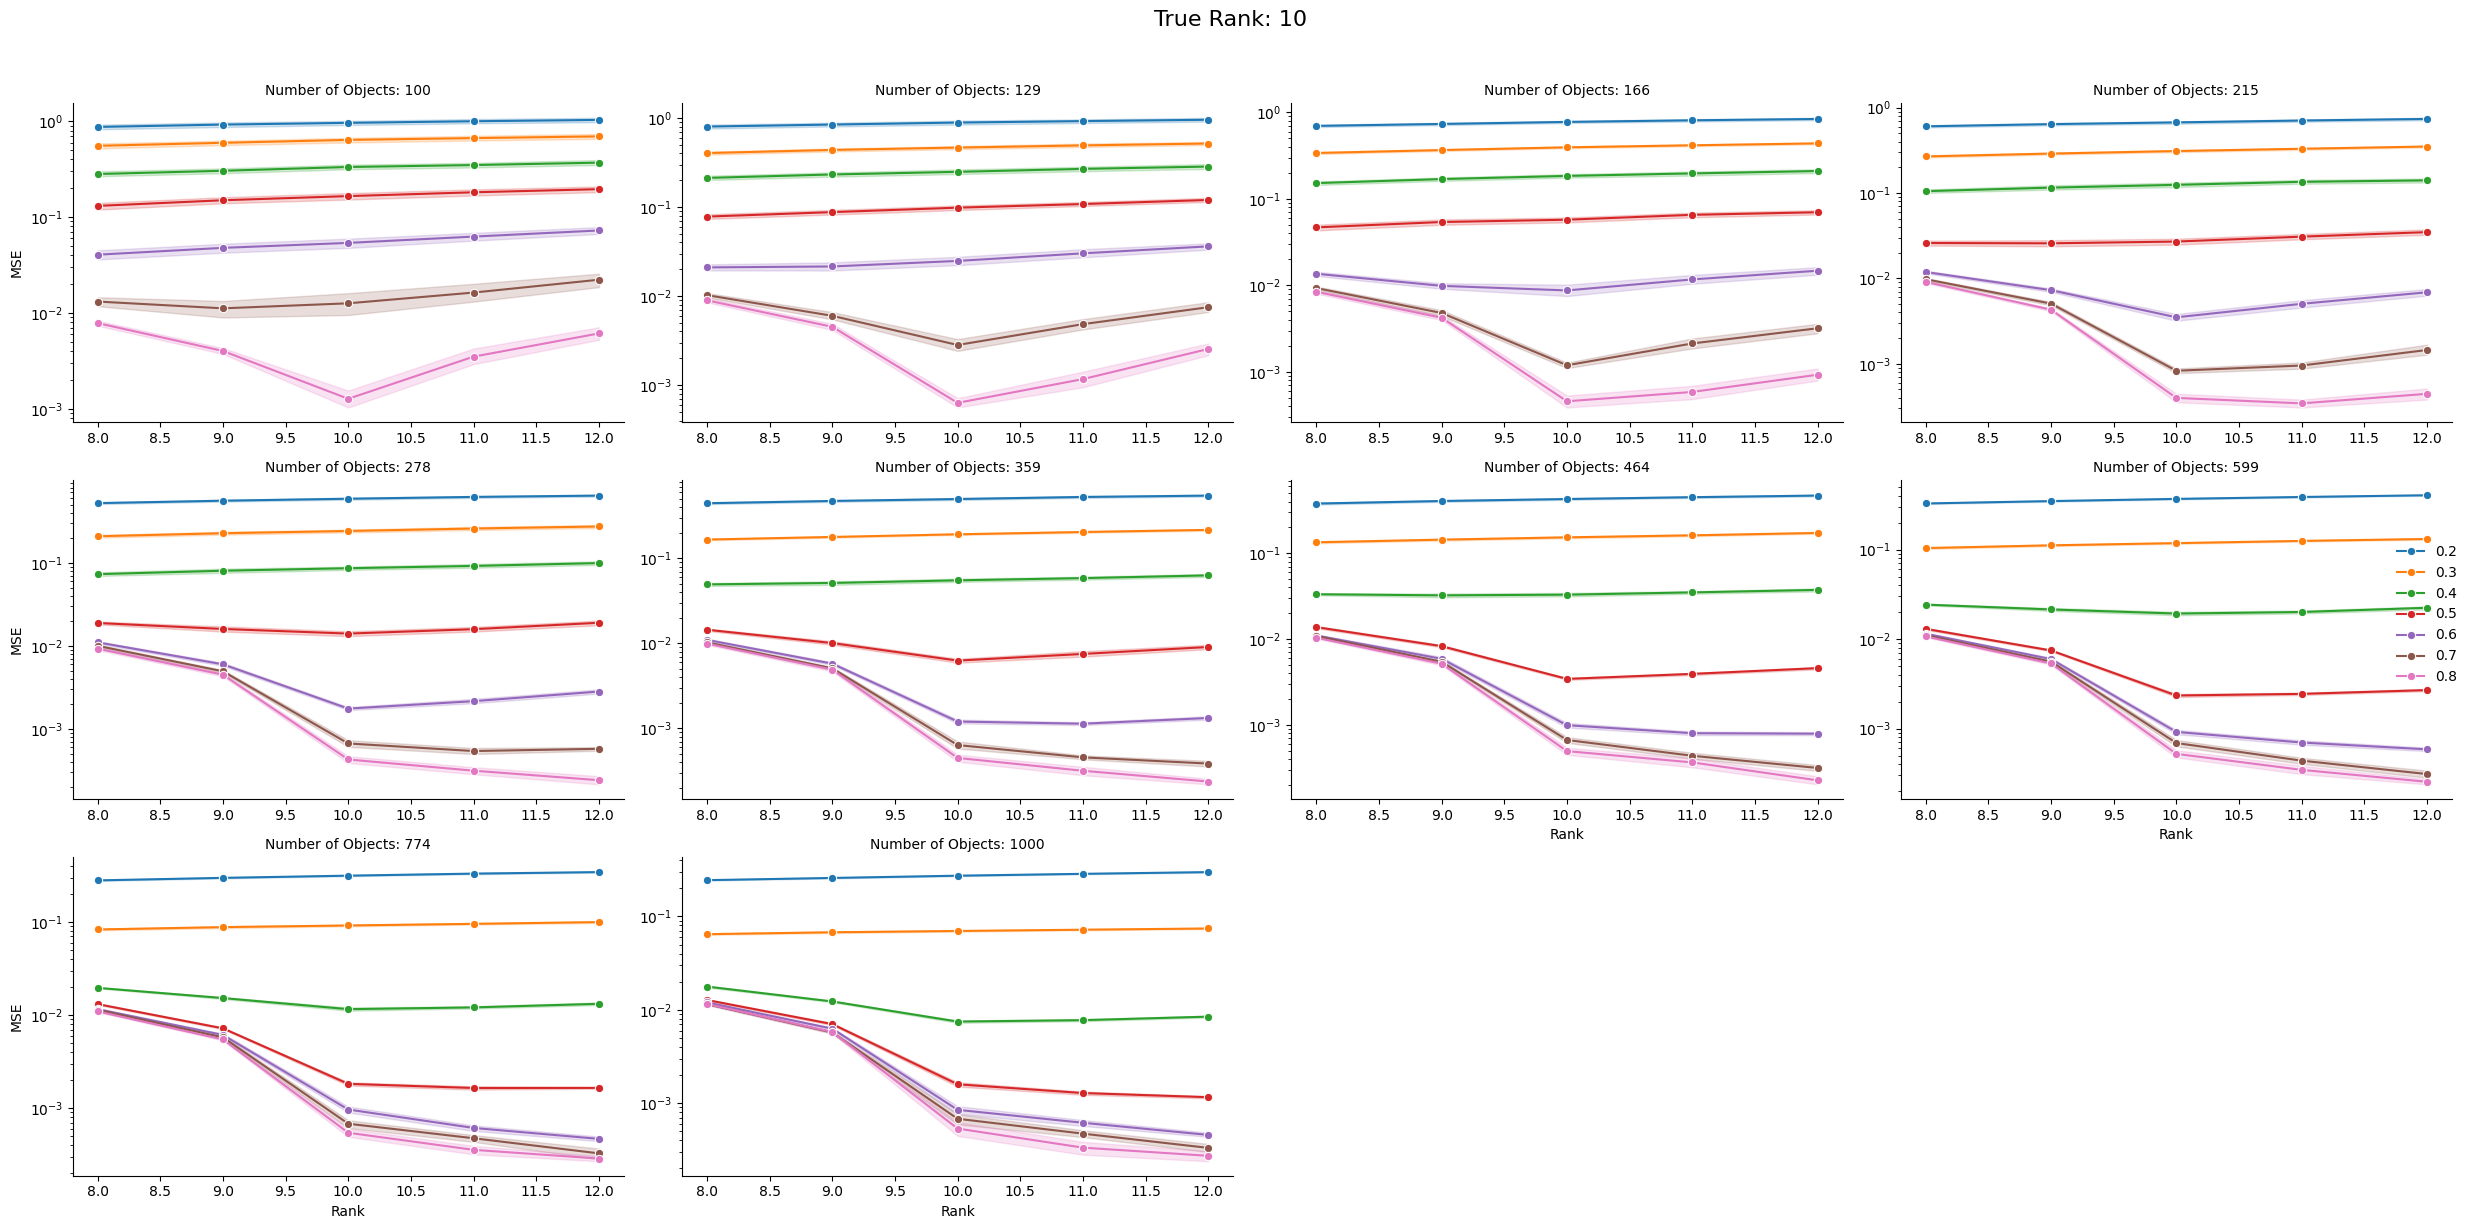

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# df = pd.read_csv("../results/rank_detection_results_test.csv")
df = pd.read_csv("../results/rank_selection/rank_detection_full_results.csv")
# df = df[df["snr"] == 1.0]
unique_true_ranks = sorted(df["true_rank"].unique())

for true_rank in unique_true_ranks:
    df_subset = df[df["true_rank"] == true_rank]

    plt.figure(dpi=300)
    g = sns.FacetGrid(
        df_subset,
        col="n_objects",
        col_wrap=4,
        height=4,
        aspect=1.5,
        sharey=False,
        sharex=False,
    )
    g.map_dataframe(
        sns.lineplot,
        x="rank",
        y="mse",
        # hue="observed_fraction",
        hue="train_ratio",
        marker="o",
        palette="tab10",
    )
    g.add_legend()
    g.set_axis_labels("Rank", "MSE")
    g.set_titles("Number of Objects: {col_name}")

    for ax in g.axes.flat:
        ax.set_yscale("log")

    plt.suptitle(f"True Rank: {true_rank}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

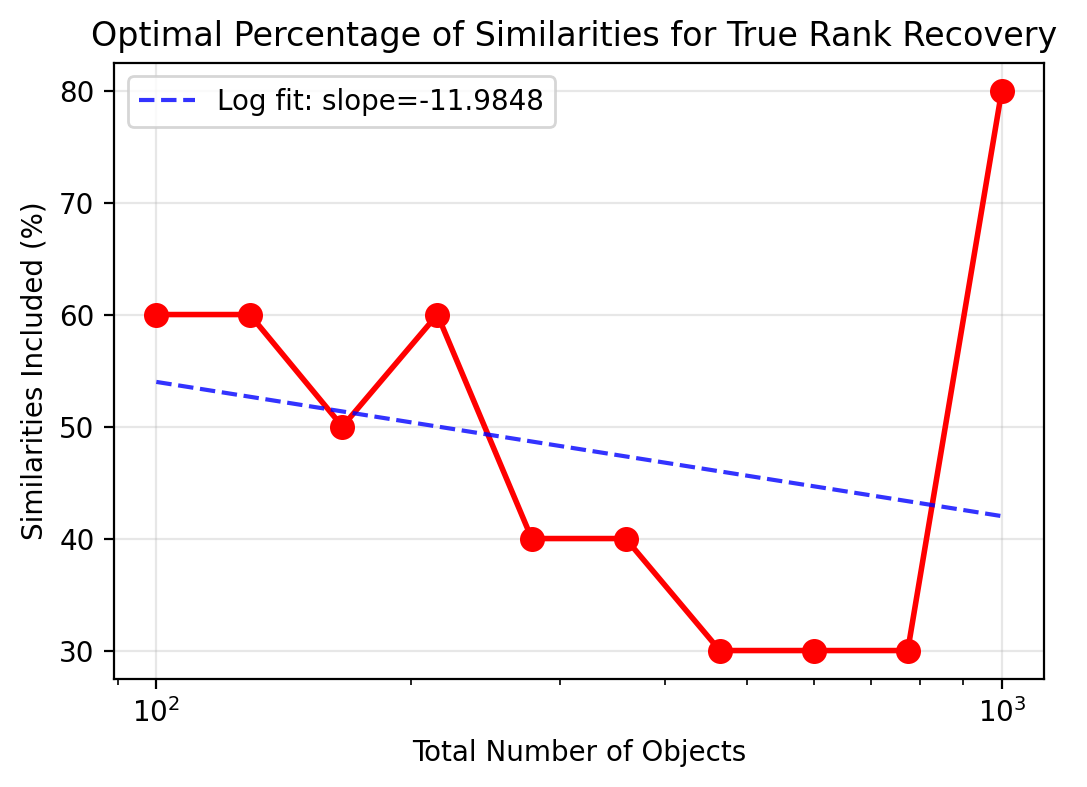

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv("../results/rank_detection_results.csv")

df = df[df["true_rank"] == 5]

# For each combination of n_objects, train_ratio, and trial_id, find the rank with minimum RMSE
best_ranks = df.groupby(["n_objects", "train_ratio", "trial_id"])["mse"].idxmin()
best_ranks_df = df.loc[best_ranks]

# Calculate accuracy (how often we recover the true rank) for each combination
best_ranks_df["correct_rank"] = best_ranks_df["rank"] == best_ranks_df["true_rank"]
accuracy_df = (
    best_ranks_df.groupby(["n_objects", "train_ratio"])["correct_rank"]
    .mean()
    .reset_index()
)

# Find optimal training ratio for each number of objects
optimal_ratios = []
object_counts = []

for n_obj in sorted(df["n_objects"].unique()):
    subset = accuracy_df[accuracy_df["n_objects"] == n_obj]
    best_ratio = subset.loc[subset["correct_rank"].idxmax(), "train_ratio"]
    optimal_ratios.append(best_ratio)
    object_counts.append(n_obj)

# Create the plot
plt.figure(figsize=(6, 4), dpi=200)
plt.plot(
    object_counts,
    np.array(optimal_ratios) * 100,
    "o-",
    linewidth=2,
    markersize=8,
    color="red",
)

# Add trend line
z = np.polyfit(np.log10(object_counts), np.array(optimal_ratios) * 100, 1)
p = np.poly1d(z)
plt.plot(
    object_counts,
    p(np.log10(object_counts)),
    "--",
    alpha=0.8,
    color="blue",
    label=f"Log fit: slope={z[0]:.4f}",
)

plt.xlabel("Total Number of Objects")
plt.ylabel("Similarities Included (%)")
plt.title("Optimal Percentage of Similarities for True Rank Recovery ")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xscale("log")

plt.show()

In [36]:
df = pd.read_csv("../results/rank_detection_results.csv")

best_ranks = df.groupby(
    ["n_objects", "observed_fraction", "true_rank", "snr", "trial_id"]
)["mse"].idxmin()
best_ranks_df = df.loc[best_ranks]

best_ranks_df["correct_rank"] = best_ranks_df["rank"] == best_ranks_df["true_rank"]

accuracy_df = (
    best_ranks_df.groupby(["n_objects", "observed_fraction", "true_rank", "snr"])[
        "correct_rank"
    ]
    .agg(["mean", "std"])
    .reset_index()
)
accuracy_df.columns = [
    "n_objects",
    "observed_fraction",
    "true_rank",
    "snr",
    "accuracy",
    "accuracy_std",
]

In [43]:
ten = df[df["true_rank"] == 10]

n_objects  observed_fraction  trial_id  rank  true_rank       mse  \
10500        100                0.2         0     8         10  0.120798   
10501        100                0.2         0     9         10  0.125476   
10502        100                0.2         0    10         10  0.144061   
10503        100                0.2         0    11         10  0.145780   
10504        100                0.2         0    12         10  0.148720   
...          ...                ...       ...   ...        ...       ...   
20995       1000                0.8         9     8         10  0.002431   
20996       1000                0.8         9     9         10  0.001169   
20997       1000                0.8         9    10         10  0.000134   
20998       1000                0.8         9    11         10  0.000096   
20999       1000                0.8         9    12         10  0.000042   

       seed  snr  
10500  2100  0.3  
10501  2100  0.3  
10502  2100  0.3  
10503  2100  0.3  
10504  2100  0.3  
...     ...  ...  
20995  4199  1.0  
20996  4199  1.0  
20997  4199  1.0  
20998  4199  1.0  
20999  4199  1.0  

[10500 rows x 8 columns]

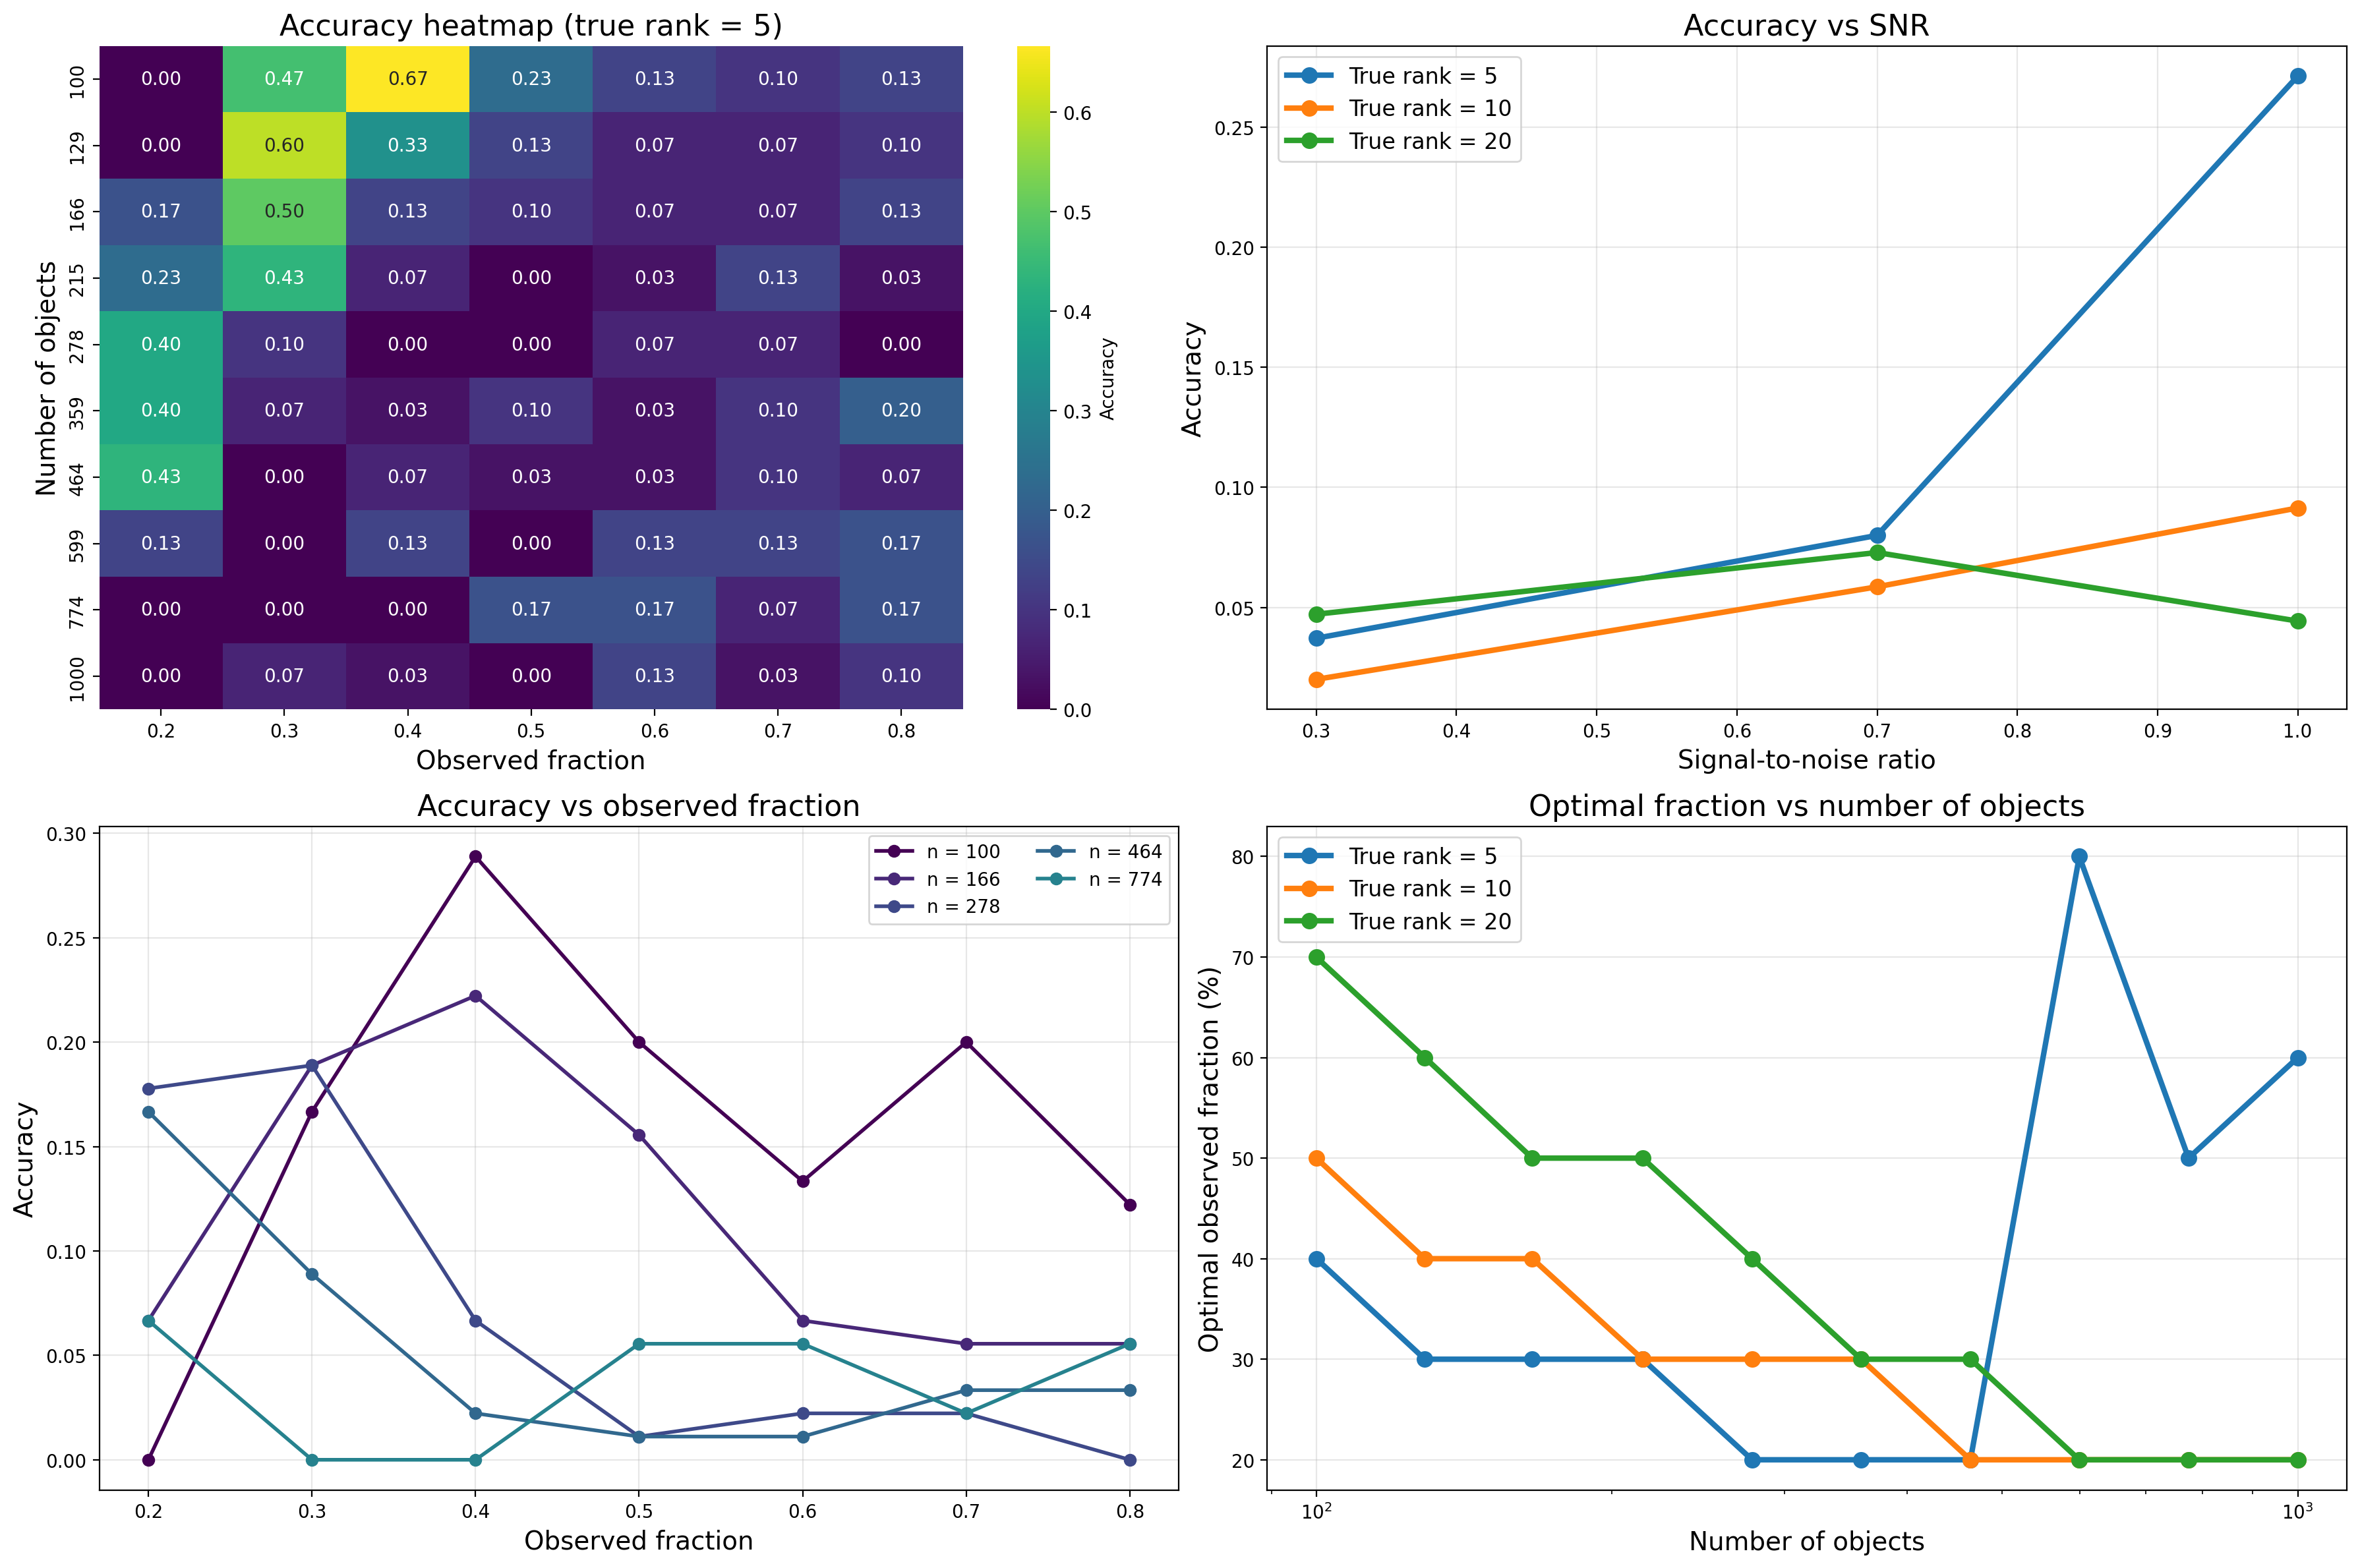

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap


fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi=200)
# fig.suptitle("Rank Recovery Performance Across Experimental Factors", fontsize=20, y=0.95)

for i, true_rank in enumerate([5, 10, 20]):
    subset = accuracy_df[accuracy_df["true_rank"] == true_rank]

    if i == 0:
        ax = axes[0, 0]
        pivot_data = (
            subset.groupby(["n_objects", "observed_fraction"])["accuracy"]
            .mean()
            .unstack()
        )
        sns.heatmap(
            pivot_data,
            ax=ax,
            cmap="viridis",
            annot=True,
            fmt=".2f",
            cbar_kws={"label": "Accuracy"},
        )
        ax.set_title(f"Accuracy heatmap (true rank = {true_rank})", fontsize=16)
        ax.set_xlabel("Observed fraction", fontsize=14)
        ax.set_ylabel("Number of objects", fontsize=14)

snr_plot_data = (
    accuracy_df.groupby(["snr", "true_rank"])["accuracy"].mean().reset_index()
)
ax = axes[0, 1]
for true_rank in [5, 10, 20]:
    data = snr_plot_data[snr_plot_data["true_rank"] == true_rank]
    ax.plot(
        data["snr"],
        data["accuracy"],
        "o-",
        linewidth=3,
        markersize=8,
        label=f"True rank = {true_rank}",
    )
ax.set_xlabel("Signal-to-noise ratio", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_title("Accuracy vs SNR", fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

fraction_plot_data = (
    accuracy_df.groupby(["observed_fraction", "n_objects"])["accuracy"]
    .mean()
    .reset_index()
)
ax = axes[1, 0]
colors = plt.cm.viridis(
    np.linspace(0, 1, len(fraction_plot_data["n_objects"].unique()))
)
for i, n_obj in enumerate(sorted(fraction_plot_data["n_objects"].unique())[::2]):
    data = fraction_plot_data[fraction_plot_data["n_objects"] == n_obj]
    ax.plot(
        data["observed_fraction"],
        data["accuracy"],
        "o-",
        linewidth=2,
        markersize=6,
        color=colors[i],
        label=f"n = {n_obj}",
    )
ax.set_xlabel("Observed fraction", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_title("Accuracy vs observed fraction", fontsize=16)
ax.legend(fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
for true_rank in [5, 10, 20]:
    optimal_fractions = []
    object_counts = []

    for n_obj in sorted(accuracy_df["n_objects"].unique()):
        subset = accuracy_df[
            (accuracy_df["n_objects"] == n_obj)
            & (accuracy_df["true_rank"] == true_rank)
        ]
        avg_accuracy = subset.groupby("observed_fraction")["accuracy"].mean()
        best_fraction = avg_accuracy.idxmax()
        optimal_fractions.append(best_fraction)
        object_counts.append(n_obj)

    ax.plot(
        object_counts,
        np.array(optimal_fractions) * 100,
        "o-",
        linewidth=3,
        markersize=8,
        label=f"True rank = {true_rank}",
    )

ax.set_xlabel("Number of objects", fontsize=14)
ax.set_ylabel("Optimal observed fraction (%)", fontsize=14)
ax.set_title("Optimal fraction vs number of objects", fontsize=16)
ax.set_xscale("log")
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

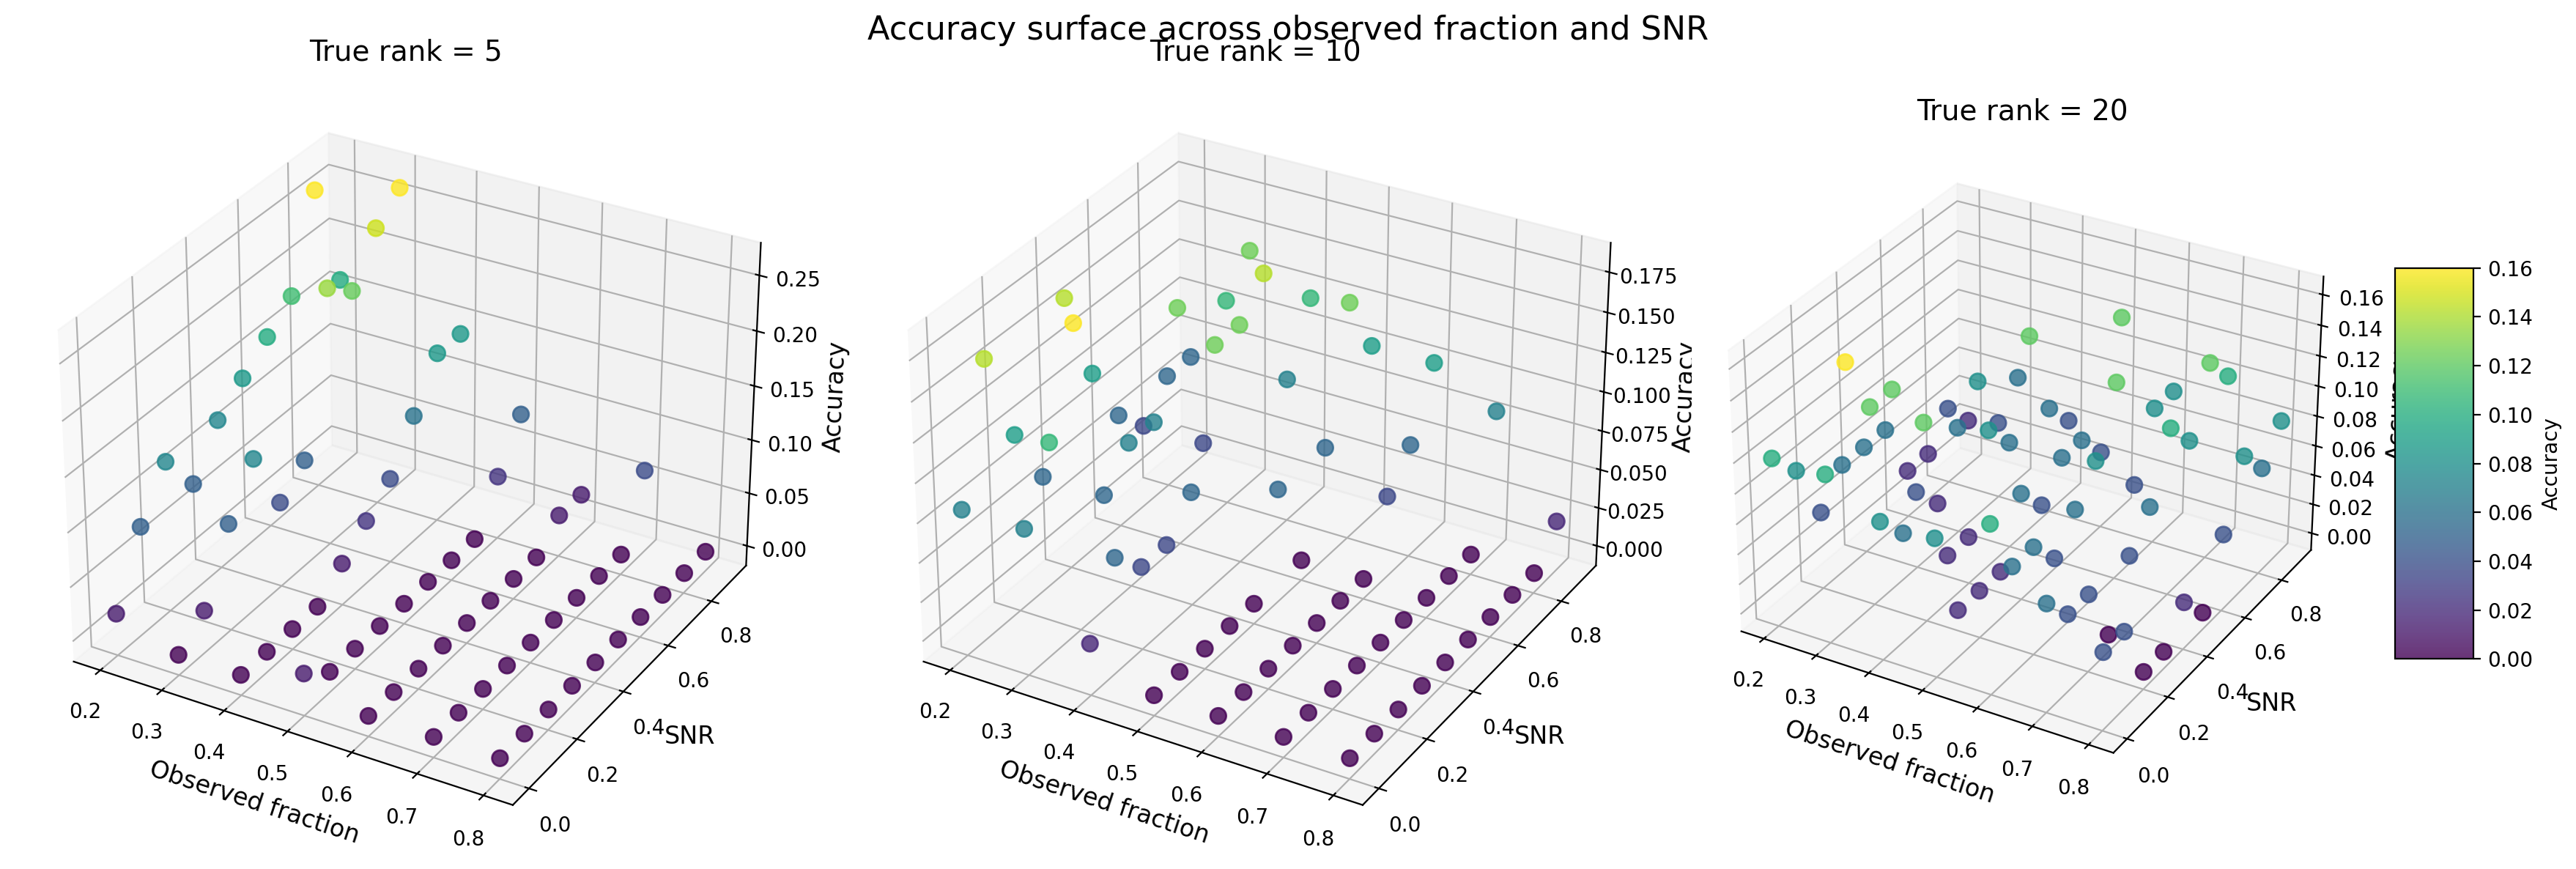

In [8]:
fig = plt.figure(figsize=(18, 6), dpi=200)

for i, true_rank in enumerate([5, 10, 20]):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")

    subset = accuracy_df[accuracy_df["true_rank"] == true_rank]
    avg_subset = (
        subset.groupby(["observed_fraction", "snr"])["accuracy"].mean().reset_index()
    )

    X = avg_subset["observed_fraction"].values
    Y = avg_subset["snr"].values
    Z = avg_subset["accuracy"].values

    scatter = ax.scatter(X, Y, Z, c=Z, cmap="viridis", s=60, alpha=0.8)

    ax.set_xlabel("Observed fraction", fontsize=12)
    ax.set_ylabel("SNR", fontsize=12)
    ax.set_zlabel("Accuracy", fontsize=12)
    ax.set_title(f"True rank = {true_rank}", fontsize=14)

    if i == 2:
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label="Accuracy")

plt.suptitle("Accuracy surface across observed fraction and SNR", fontsize=16)
plt.tight_layout()
plt.show()

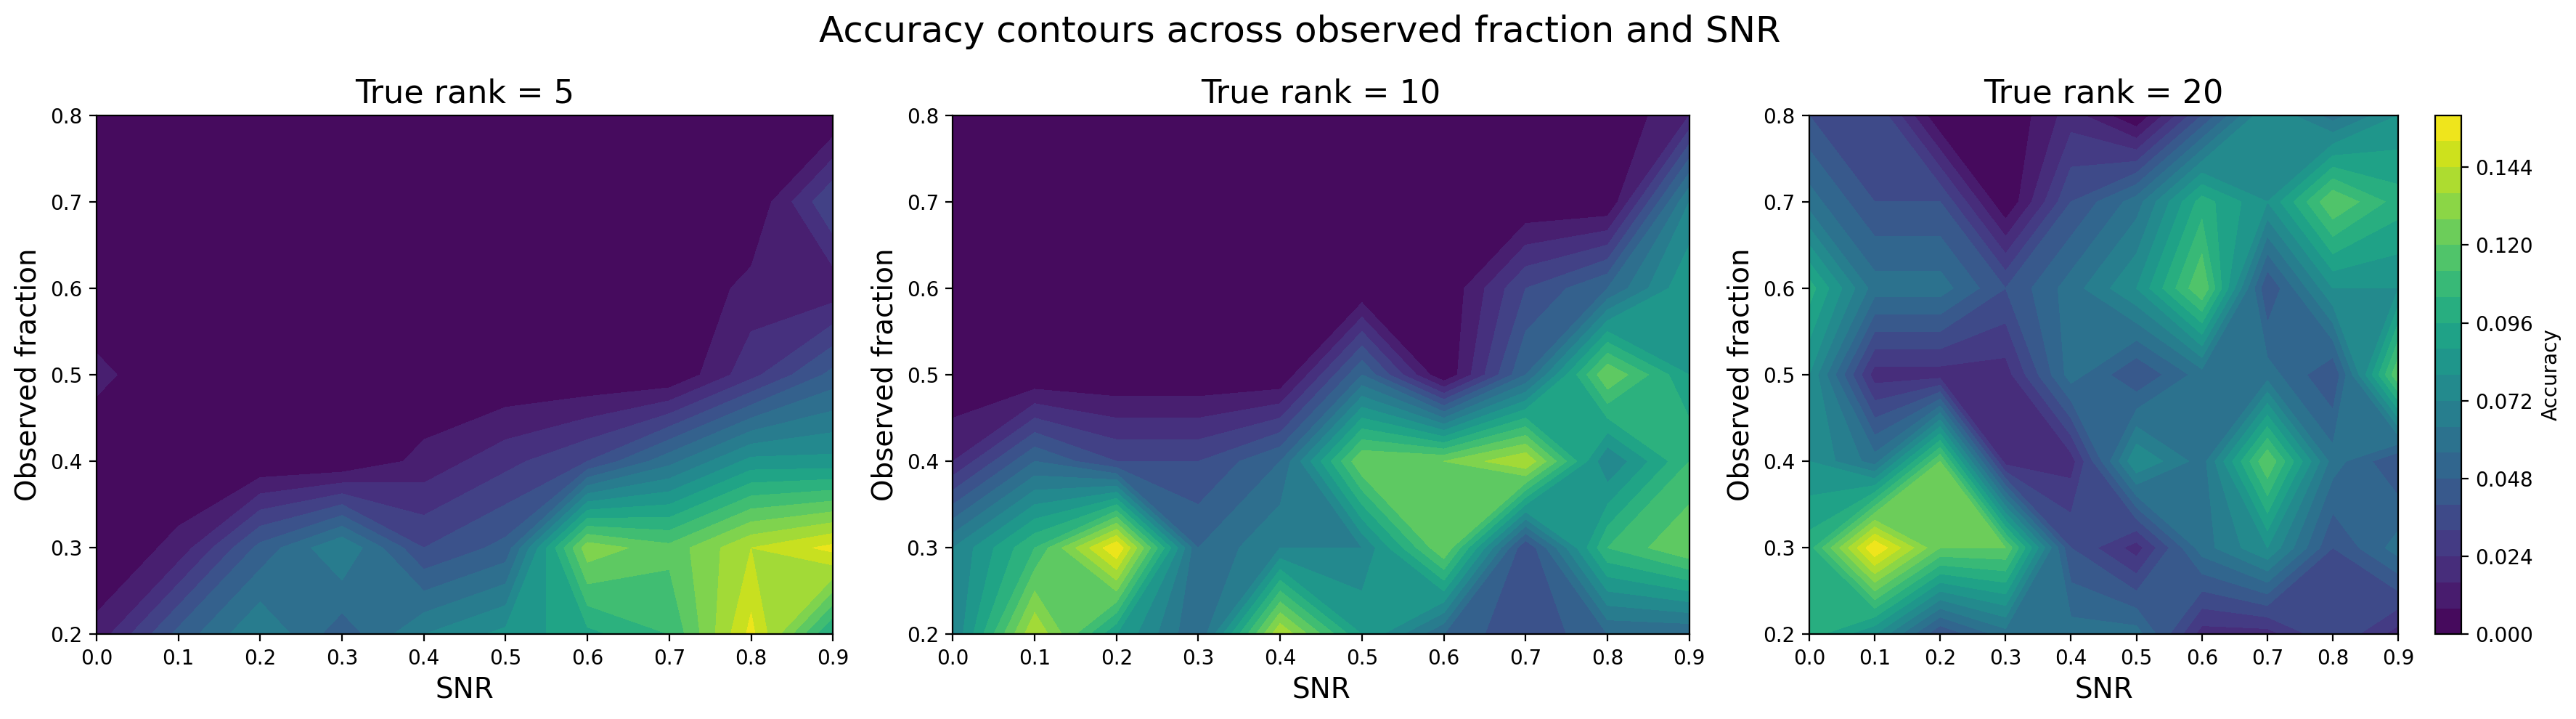

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=200)

for i, true_rank in enumerate([5, 10, 20]):
    subset = accuracy_df[accuracy_df["true_rank"] == true_rank]

    pivot_data = (
        subset.groupby(["observed_fraction", "snr"])["accuracy"].mean().unstack()
    )

    im = axes[i].contourf(
        pivot_data.columns,
        pivot_data.index,
        pivot_data.values,
        levels=20,
        cmap="viridis",
    )
    axes[i].set_xlabel("SNR", fontsize=14)
    axes[i].set_ylabel("Observed fraction", fontsize=14)
    axes[i].set_title(f"True rank = {true_rank}", fontsize=16)

    if i == 2:
        plt.colorbar(im, ax=axes[i], label="Accuracy")

plt.suptitle("Accuracy contours across observed fraction and SNR", fontsize=18)
plt.tight_layout()
plt.show()

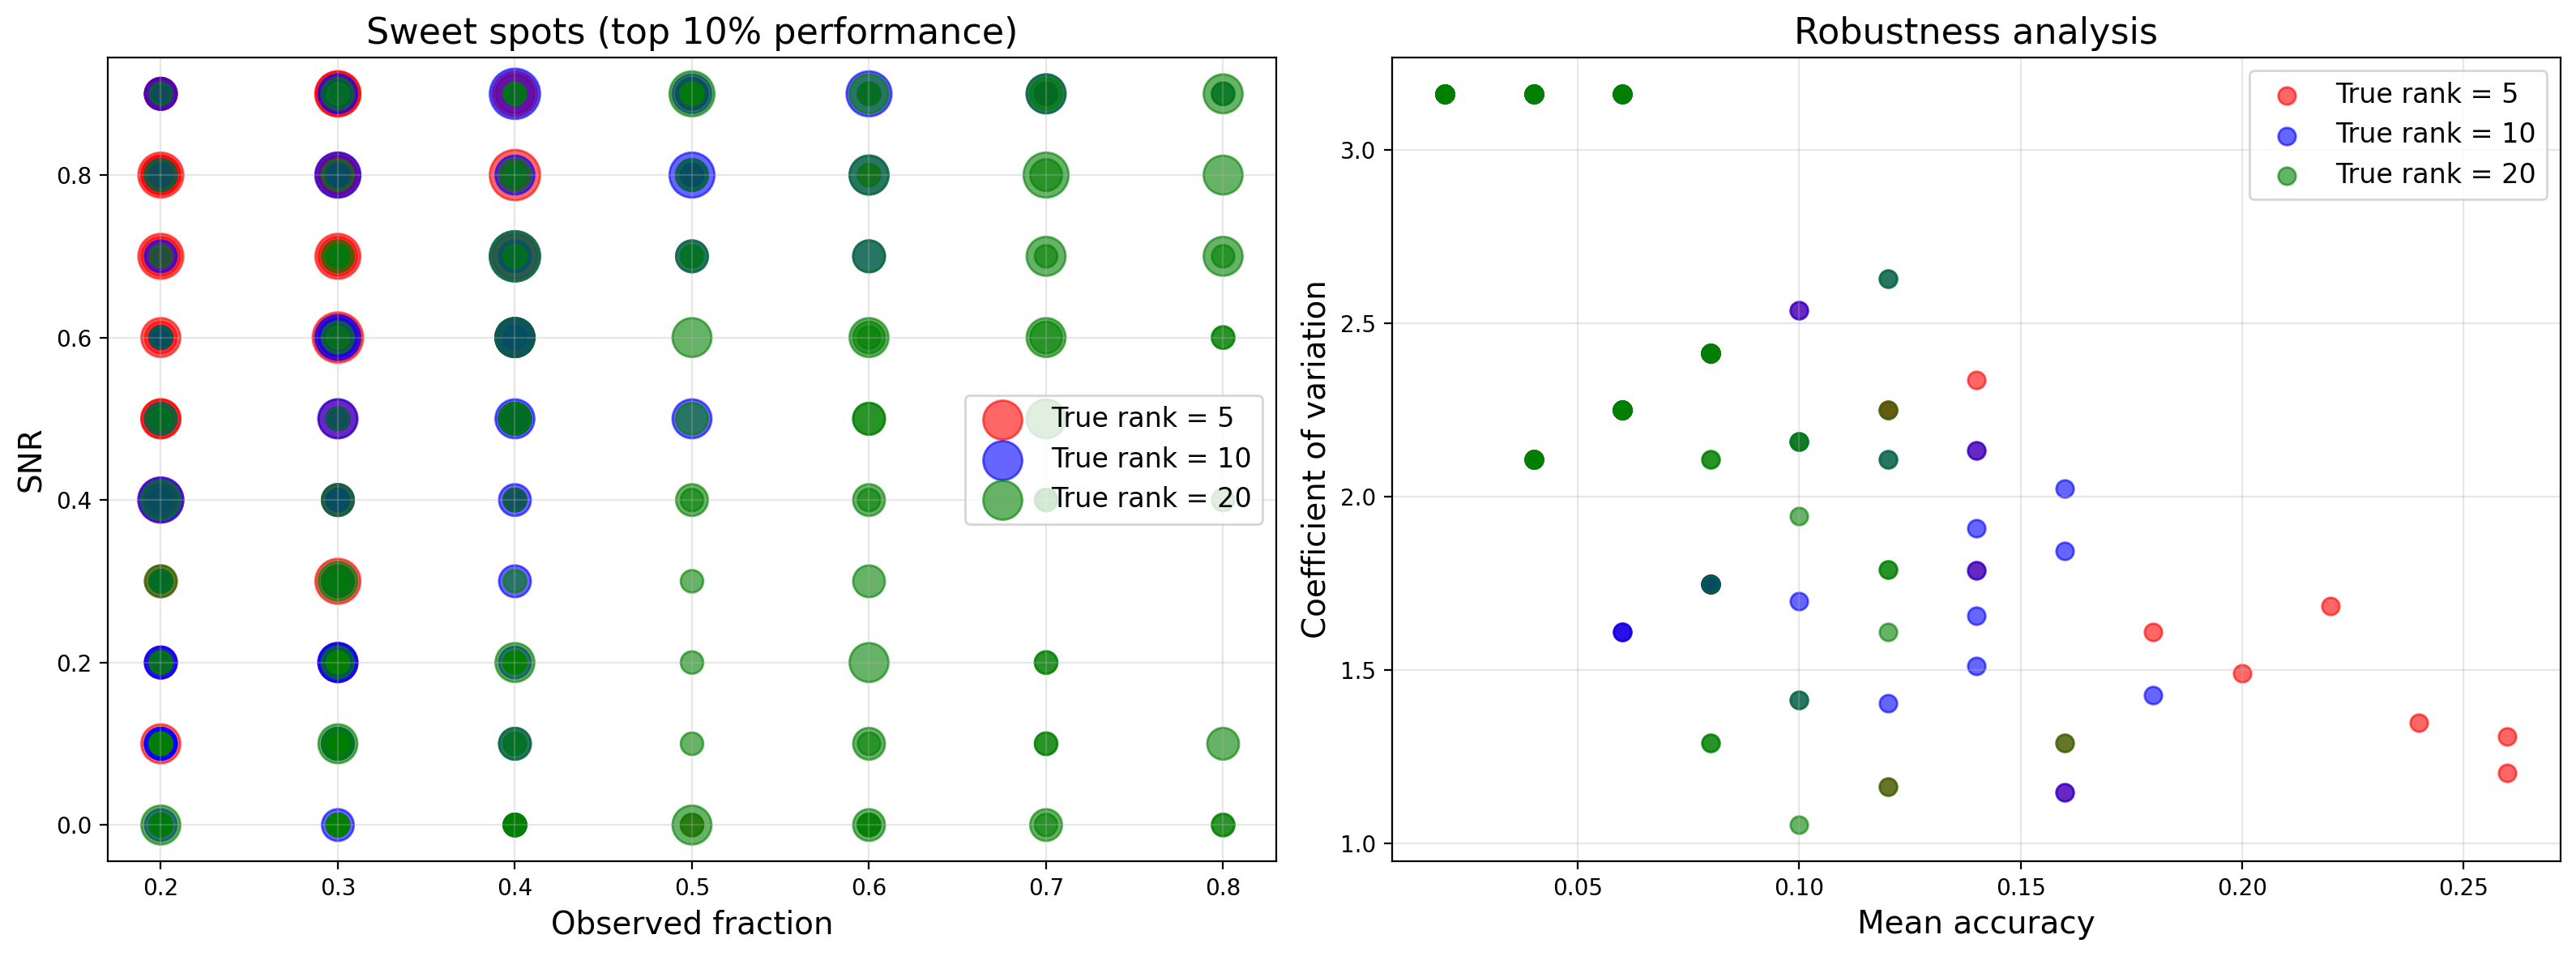

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=200)

sweet_spot_data = []
for true_rank in [5, 10, 20]:
    subset = accuracy_df[accuracy_df["true_rank"] == true_rank]

    best_conditions = subset.groupby(["n_objects", "observed_fraction", "snr"])[
        "accuracy"
    ].mean()
    top_10_percent = best_conditions.quantile(0.9)

    sweet_spots = best_conditions[best_conditions >= top_10_percent].reset_index()
    sweet_spots["true_rank"] = true_rank
    sweet_spot_data.append(sweet_spots)

sweet_spots_df = pd.concat(sweet_spot_data)

ax = axes[0]
colors = ["red", "blue", "green"]
for i, true_rank in enumerate([5, 10, 20]):
    data = sweet_spots_df[sweet_spots_df["true_rank"] == true_rank]
    ax.scatter(
        data["observed_fraction"],
        data["snr"],
        s=data["accuracy"] * 500,
        alpha=0.6,
        color=colors[i],
        label=f"True rank = {true_rank}",
    )

ax.set_xlabel("Observed fraction", fontsize=14)
ax.set_ylabel("SNR", fontsize=14)
ax.set_title("Sweet spots (top 10% performance)", fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

robustness_data = (
    accuracy_df.groupby(["true_rank", "observed_fraction", "snr"])
    .agg({"accuracy": ["mean", "std"]})
    .reset_index()
)
robustness_data.columns = [
    "true_rank",
    "observed_fraction",
    "snr",
    "mean_accuracy",
    "std_accuracy",
]
robustness_data["cv"] = (
    robustness_data["std_accuracy"] / robustness_data["mean_accuracy"]
)

ax = axes[1]
for i, true_rank in enumerate([5, 10, 20]):
    data = robustness_data[robustness_data["true_rank"] == true_rank]
    ax.scatter(
        data["mean_accuracy"],
        data["cv"],
        alpha=0.6,
        color=colors[i],
        s=60,
        label=f"True rank = {true_rank}",
    )

ax.set_xlabel("Mean accuracy", fontsize=14)
ax.set_ylabel("Coefficient of variation", fontsize=14)
ax.set_title("Robustness analysis", fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv("../results/rank_detection_results.csv")

best_ranks = df.groupby(
    ["n_objects", "observed_fraction", "true_rank", "snr", "trial_id"]
)["mse"].idxmin()
best_ranks_df = df.loc[best_ranks]
best_ranks_df["correct_rank"] = best_ranks_df["rank"] == best_ranks_df["true_rank"]

accuracy_df = (
    best_ranks_df.groupby(["n_objects", "observed_fraction", "true_rank", "snr"])[
        "correct_rank"
    ]
    .mean()
    .reset_index()
)

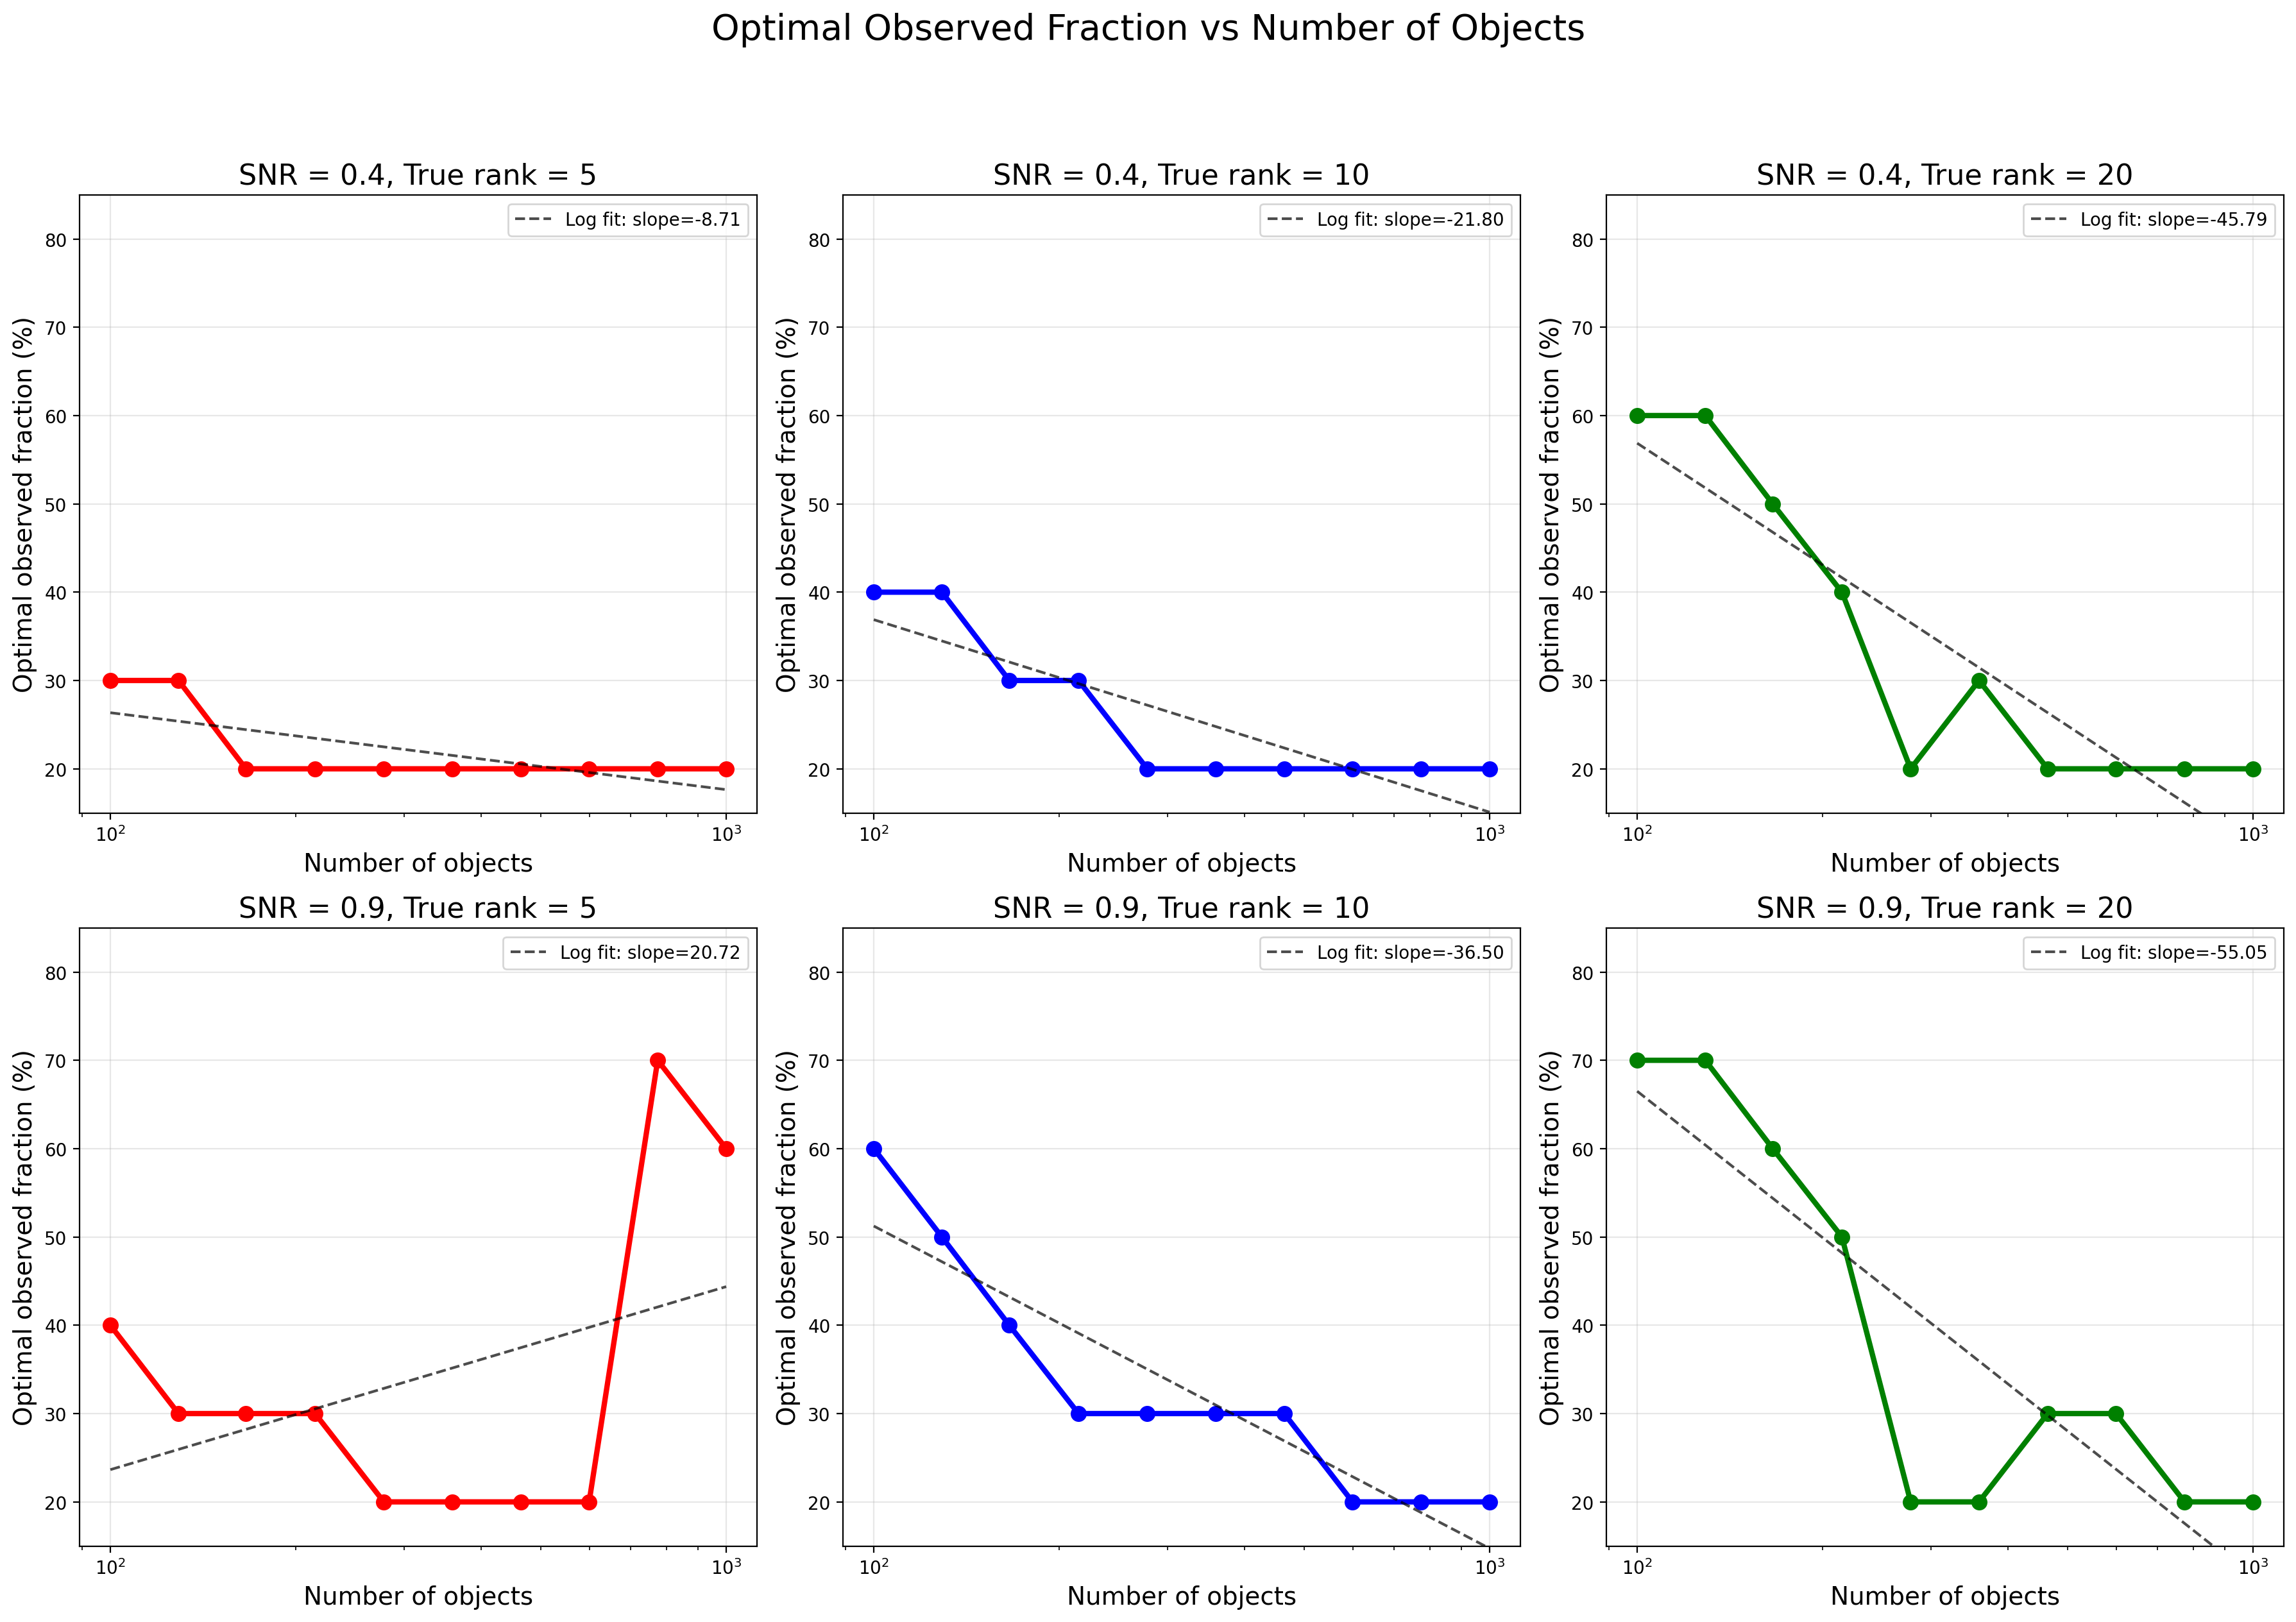

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=200)

snr_levels = [0.4, 0.9]
true_ranks = [5, 10, 20]
colors = ["red", "blue", "green"]

for row, snr in enumerate(snr_levels):
    for col, true_rank in enumerate(true_ranks):
        ax = axes[row, col]

        subset = accuracy_df[
            (accuracy_df["snr"] == snr) & (accuracy_df["true_rank"] == true_rank)
        ]

        optimal_fractions = []
        object_counts = []
        max_accuracies = []

        for n_obj in sorted(subset["n_objects"].unique()):
            obj_subset = subset[subset["n_objects"] == n_obj]
            if len(obj_subset) > 0:
                best_idx = obj_subset["correct_rank"].idxmax()
                best_fraction = obj_subset.loc[best_idx, "observed_fraction"]
                max_accuracy = obj_subset.loc[best_idx, "correct_rank"]

                optimal_fractions.append(best_fraction)
                object_counts.append(n_obj)
                max_accuracies.append(max_accuracy)

        ax.plot(
            object_counts,
            np.array(optimal_fractions) * 100,
            "o-",
            linewidth=3,
            markersize=8,
            color=colors[col],
        )

        if len(object_counts) > 3:
            z = np.polyfit(
                np.log10(object_counts), np.array(optimal_fractions) * 100, 1
            )
            p = np.poly1d(z)
            ax.plot(
                object_counts,
                p(np.log10(object_counts)),
                "--",
                alpha=0.7,
                color="black",
                label=f"Log fit: slope={z[0]:.2f}",
            )
            ax.legend(fontsize=10)

        ax.set_xlabel("Number of objects", fontsize=14)
        ax.set_ylabel("Optimal observed fraction (%)", fontsize=14)
        ax.set_title(f"SNR = {snr}, True rank = {true_rank}", fontsize=16)
        ax.set_xscale("log")
        ax.grid(True, alpha=0.3)
        ax.set_ylim(15, 85)

plt.suptitle("Optimal Observed Fraction vs Number of Objects", fontsize=20, y=1.05)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2264684/3944115739.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(object_counts, np.array(optimal_fractions) * 100, 'o-',
/tmp/ipykernel_2264684/3944115739.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(object_counts, np.array(optimal_fractions) * 100, 'o-',
/tmp/ipykernel_2264684/3944115739.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(object_counts, np.array(optimal_fractions) * 100, 'o-',
/tmp/ipykernel_2264684/3944115739.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The k

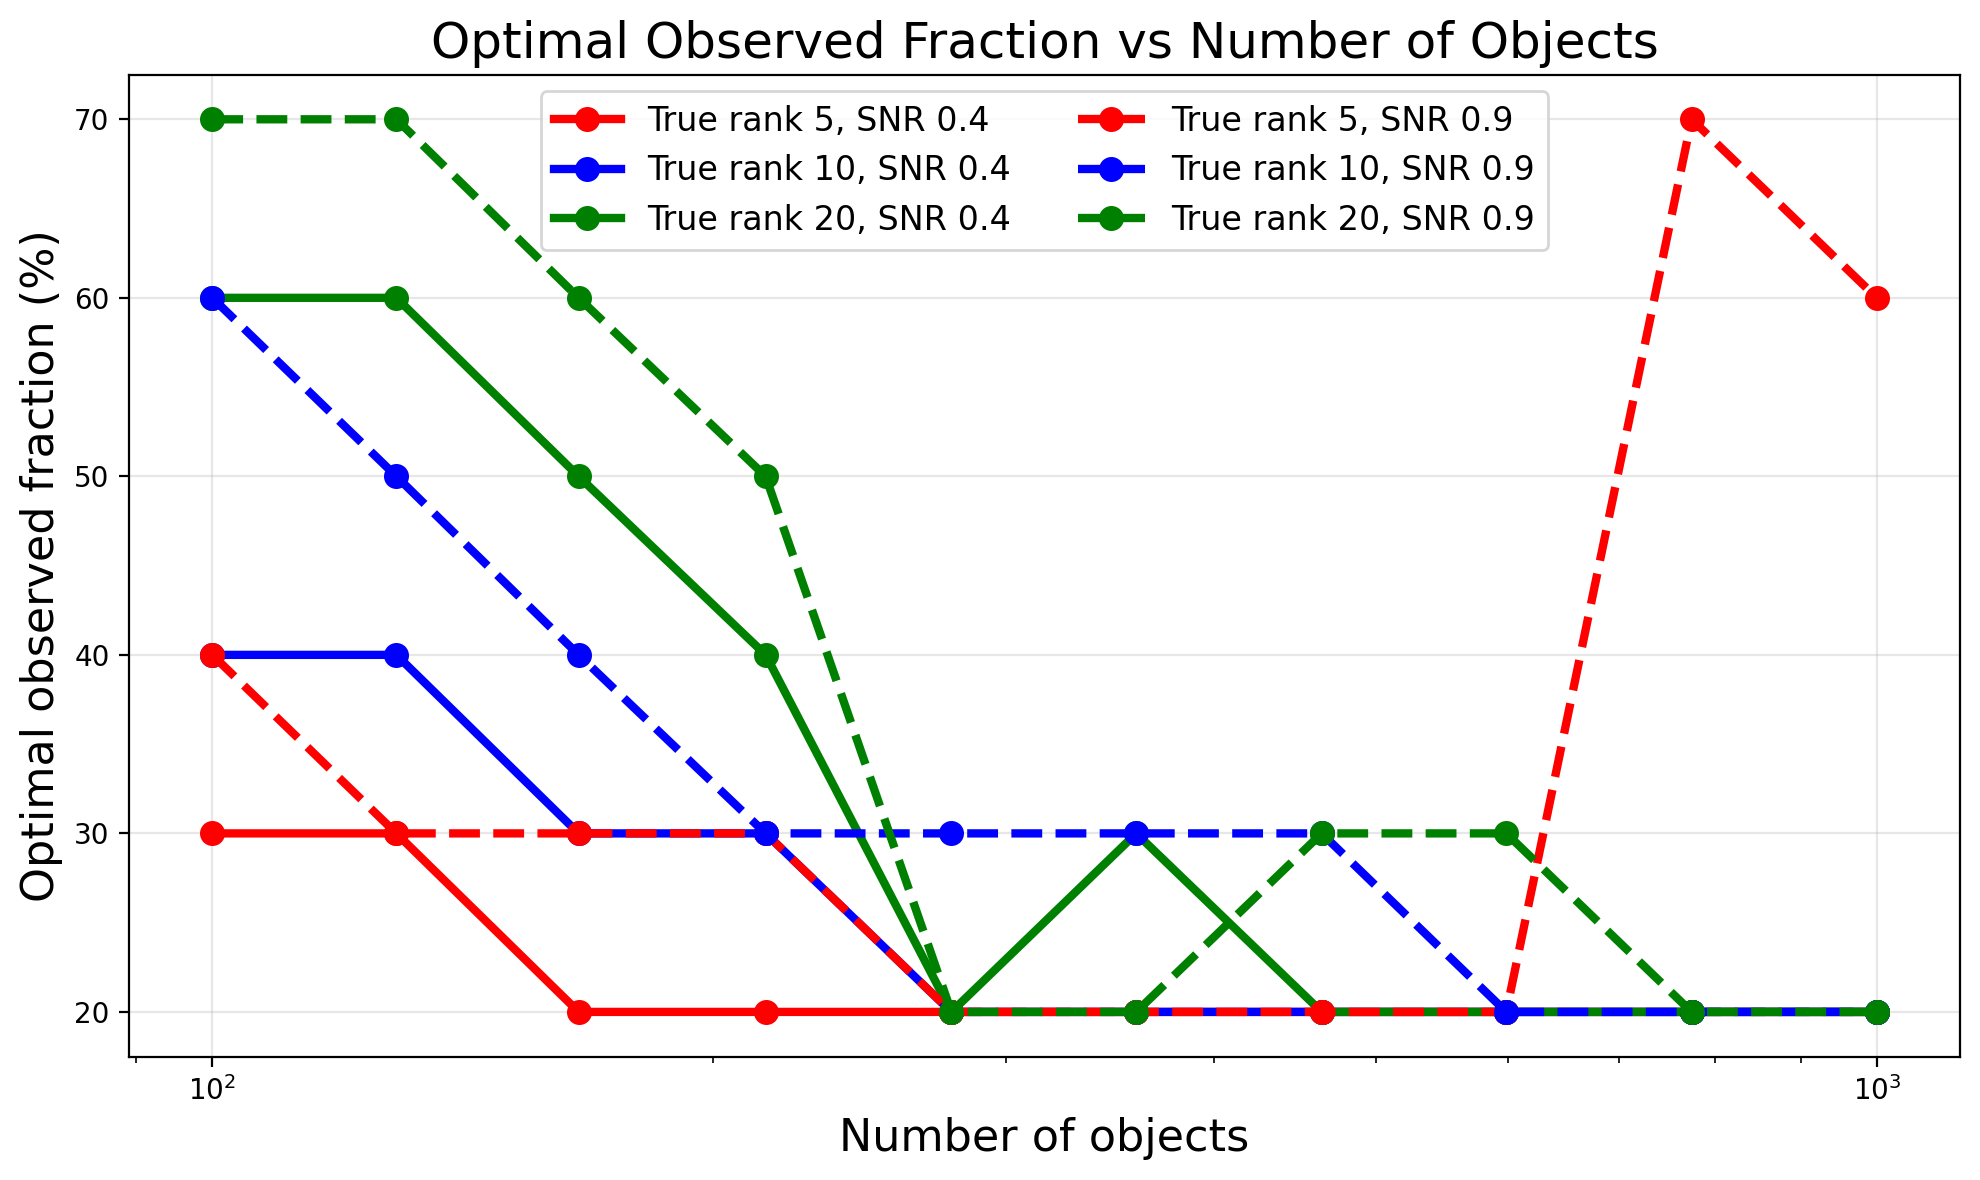

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

for snr in [0.4, 0.9]:
    for i, true_rank in enumerate([5, 10, 20]):
        subset = accuracy_df[
            (accuracy_df["snr"] == snr) & (accuracy_df["true_rank"] == true_rank)
        ]

        optimal_fractions = []
        object_counts = []

        for n_obj in sorted(subset["n_objects"].unique()):
            obj_subset = subset[subset["n_objects"] == n_obj]
            if len(obj_subset) > 0:
                best_idx = obj_subset["correct_rank"].idxmax()
                best_fraction = obj_subset.loc[best_idx, "observed_fraction"]
                optimal_fractions.append(best_fraction)
                object_counts.append(n_obj)

        linestyle = "-" if snr == 0.4 else "--"
        ax.plot(
            object_counts,
            np.array(optimal_fractions) * 100,
            "o-",
            linewidth=3,
            markersize=8,
            color=colors[i],
            linestyle=linestyle,
            label=f"True rank {true_rank}, SNR {snr}",
        )

ax.set_xlabel("Number of objects", fontsize=16)
ax.set_ylabel("Optimal observed fraction (%)", fontsize=16)
ax.set_title("Optimal Observed Fraction vs Number of Objects", fontsize=18)
ax.set_xscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, ncol=2)
plt.tight_layout()
plt.show()

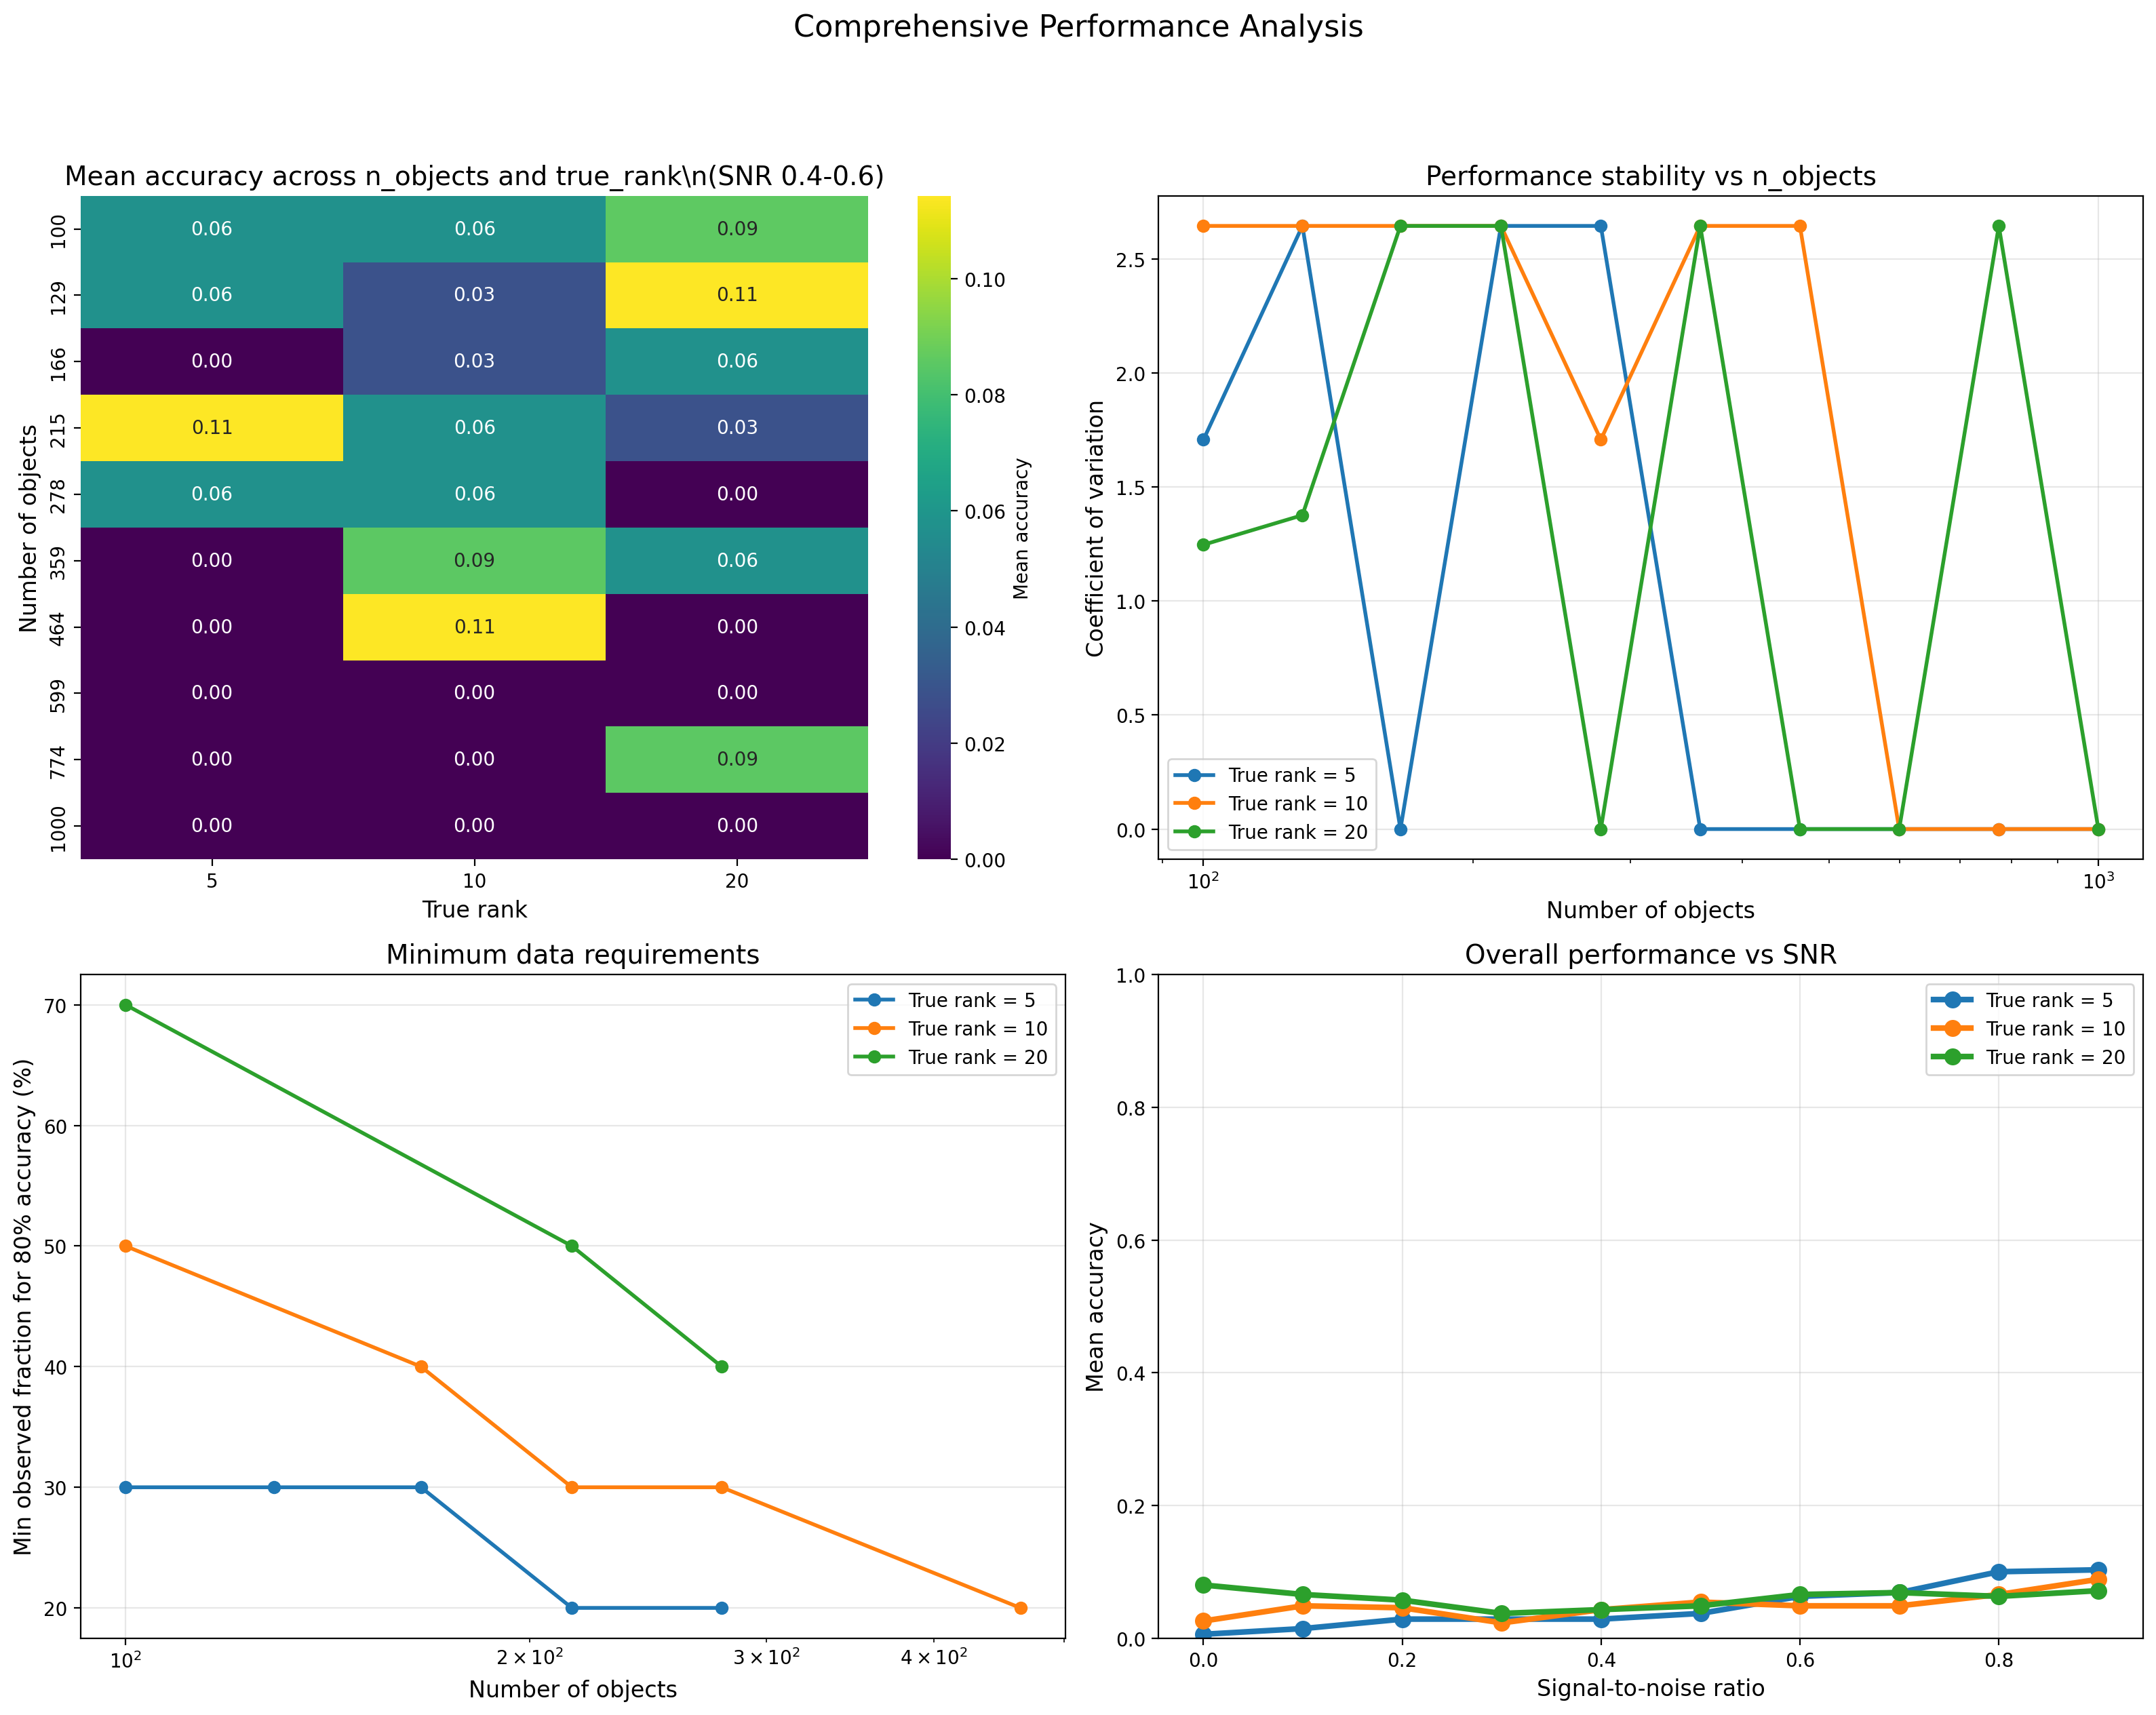

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=200)

subset_snr = accuracy_df[accuracy_df["snr"].isin([0.4, 0.6])]

ax = axes[0, 0]
heatmap_data = (
    subset_snr.groupby(["n_objects", "true_rank"])["correct_rank"].mean().unstack()
)
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    ax=ax,
    cbar_kws={"label": "Mean accuracy"},
)
ax.set_title(
    "Mean accuracy across n_objects and true_rank\\n(SNR 0.4-0.6)", fontsize=14
)
ax.set_xlabel("True rank", fontsize=12)
ax.set_ylabel("Number of objects", fontsize=12)

ax = axes[0, 1]
robustness_data = (
    subset_snr.groupby(["n_objects", "true_rank"])
    .agg({"correct_rank": ["mean", "std"]})
    .reset_index()
)
robustness_data.columns = ["n_objects", "true_rank", "mean_acc", "std_acc"]
robustness_data["cv"] = robustness_data["std_acc"] / (
    robustness_data["mean_acc"] + 1e-8
)

for true_rank in [5, 10, 20]:
    data = robustness_data[robustness_data["true_rank"] == true_rank]
    ax.plot(
        data["n_objects"],
        data["cv"],
        "o-",
        linewidth=2,
        markersize=6,
        label=f"True rank = {true_rank}",
    )

ax.set_xlabel("Number of objects", fontsize=12)
ax.set_ylabel("Coefficient of variation", fontsize=12)
ax.set_title("Performance stability vs n_objects", fontsize=14)
ax.set_xscale("log")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
difficulty_analysis = []
for true_rank in [5, 10, 20]:
    for n_obj in sorted(accuracy_df["n_objects"].unique()):
        subset = accuracy_df[
            (accuracy_df["true_rank"] == true_rank)
            & (accuracy_df["n_objects"] == n_obj)
        ]
        max_acc = subset["correct_rank"].max()
        min_fraction_needed = subset[subset["correct_rank"] >= 0.8][
            "observed_fraction"
        ].min()

        difficulty_analysis.append(
            {
                "true_rank": true_rank,
                "n_objects": n_obj,
                "max_accuracy": max_acc,
                "min_fraction_80pct": min_fraction_needed,
            }
        )

difficulty_df = pd.DataFrame(difficulty_analysis)
difficulty_df = difficulty_df.dropna()

for true_rank in [5, 10, 20]:
    data = difficulty_df[difficulty_df["true_rank"] == true_rank]
    ax.plot(
        data["n_objects"],
        data["min_fraction_80pct"] * 100,
        "o-",
        linewidth=2,
        markersize=6,
        label=f"True rank = {true_rank}",
    )

ax.set_xlabel("Number of objects", fontsize=12)
ax.set_ylabel("Min observed fraction for 80% accuracy (%)", fontsize=12)
ax.set_title("Minimum data requirements", fontsize=14)
ax.set_xscale("log")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
snr_comparison = (
    accuracy_df.groupby(["snr", "true_rank"])["correct_rank"].mean().reset_index()
)

for true_rank in [5, 10, 20]:
    data = snr_comparison[snr_comparison["true_rank"] == true_rank]
    ax.plot(
        data["snr"],
        data["correct_rank"],
        "o-",
        linewidth=3,
        markersize=8,
        label=f"True rank = {true_rank}",
    )

ax.set_xlabel("Signal-to-noise ratio", fontsize=12)
ax.set_ylabel("Mean accuracy", fontsize=12)
ax.set_title("Overall performance vs SNR", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.suptitle("Comprehensive Performance Analysis", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 3000x800 with 0 Axes>

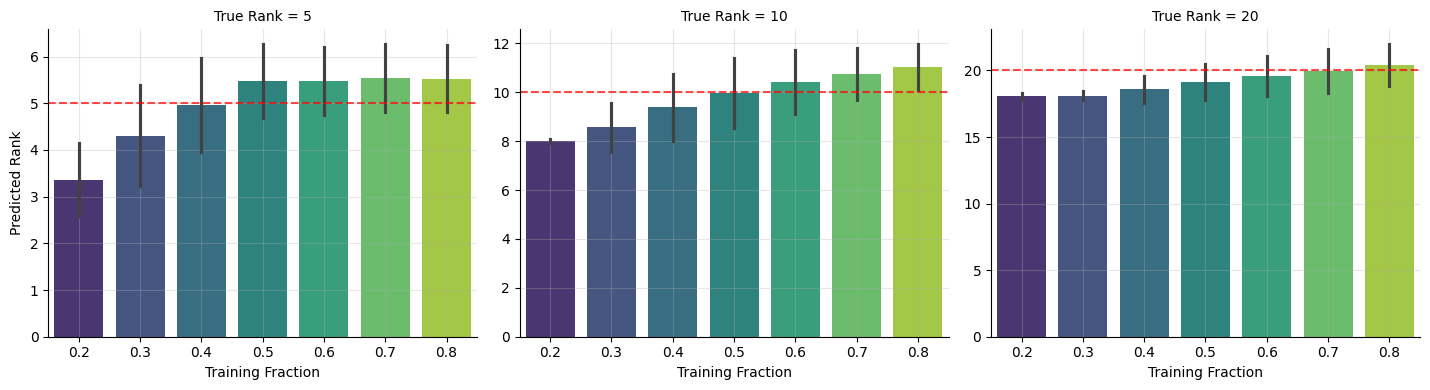

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../results/rank_detection_results.csv")

predicted_ranks = df.loc[
    df.groupby(["n_objects", "train_ratio", "trial_id", "true_rank"])["mse"].idxmin()
][["n_objects", "train_ratio", "trial_id", "true_rank", "rank", "mse"]].copy()

predicted_ranks = predicted_ranks.rename(columns={"rank": "predicted_rank"})

plt.figure(figsize=(15, 4), dpi=200)
g = sns.FacetGrid(
    predicted_ranks,
    col="true_rank",
    height=4,
    aspect=1.2,
    sharey=False,
)
g.map_dataframe(
    sns.barplot,
    x="train_ratio",
    y="predicted_rank",
    errorbar="sd",
    palette="viridis",
)
g.set_axis_labels("Training Fraction", "Predicted Rank")
g.set_titles("True Rank = {col_name}")

for ax, true_rank in zip(g.axes.flat, sorted(predicted_ranks["true_rank"].unique())):
    ax.axhline(y=true_rank, color="red", linestyle="--", alpha=0.7)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

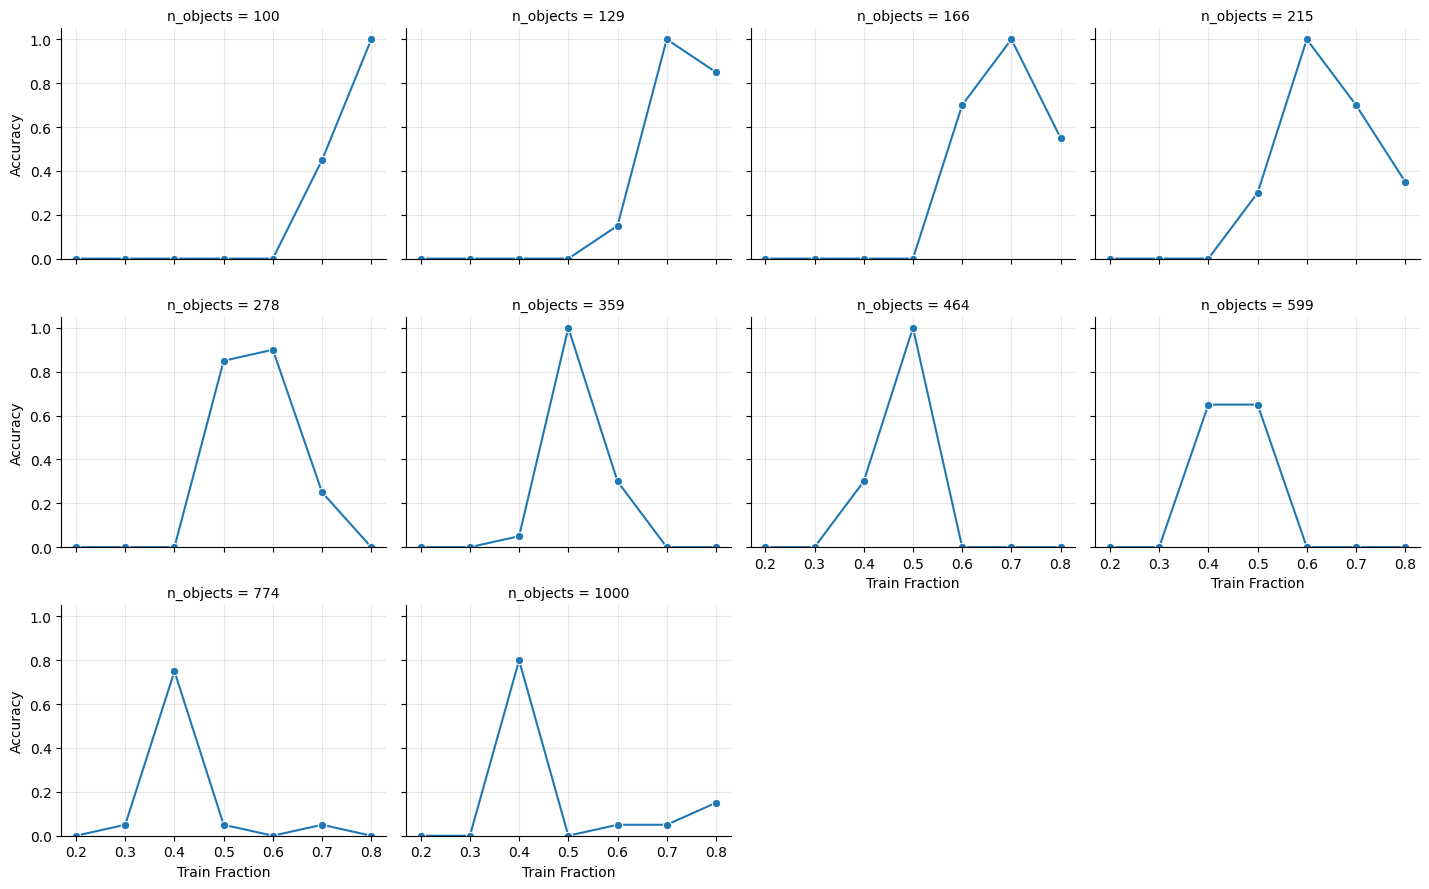

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("../results/rank_selection/rank_detection_full_results.csv")

# For each (n_objects, train_ratio, trial_id), find the rank with minimum mse
best_ranks = df.loc[
    df.groupby(["n_objects", "train_ratio", "trial_id"])["mse"].idxmin()
]

# Add a column indicating whether the selected rank matches the true rank
best_ranks["correct_rank"] = (best_ranks["rank"] == best_ranks["true_rank"]).astype(int)

# Compute accuracy (fraction of correct rank selections) for each (n_objects, train_ratio)
accuracy = (
    best_ranks.groupby(["n_objects", "train_ratio"])["correct_rank"]
    .mean()
    .reset_index()
    .rename(columns={"correct_rank": "accuracy"})
)

# Plot accuracy as a function of train_ratio, faceted by n_objects
g = sns.FacetGrid(
    accuracy,
    col="n_objects",
    col_wrap=4,
    sharey=True,
    height=3,
    aspect=1.2,
)
g.map_dataframe(sns.lineplot, x="train_ratio", y="accuracy", marker="o")
g.set_axis_labels("Train Fraction", "Accuracy")
g.set_titles("n_objects = {col_name}")
for ax in g.axes.flatten():
    ax.set_ylim(0, 1.05)
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Checking the rank selection for eg DNNs etc

In [40]:
peterson = load_dataset("peterson-animals")
rsm = peterson.rsm

import numpy as np
from cross_validation import cross_val_score

df = cross_val_score(
    rsm,
    observed_fraction=0.6,
    n_repeats=100,
    param_grid={"rank": np.arange(2, 46, 2), "max_outer": [10], "max_inner": [20]},
)

Running 2200 jobs (22 params x 100 CV splits)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2200 out of 2200 | elapsed:  3.6min finished


In [44]:
from utils.helpers import compute_subsampling_fraction_symmetric

frac = compute_subsampling_fraction_symmetric(rsm, constant=0.01)

Effective rank: 45.006611759421894
Required samples: 1237.8660185526903
Degrees of freedom: 7260
Fraction of entries to sample: 0.17050496123315292


{'max_inner': np.int64(20), 'max_outer': np.int64(10), 'rank': np.int64(10)}


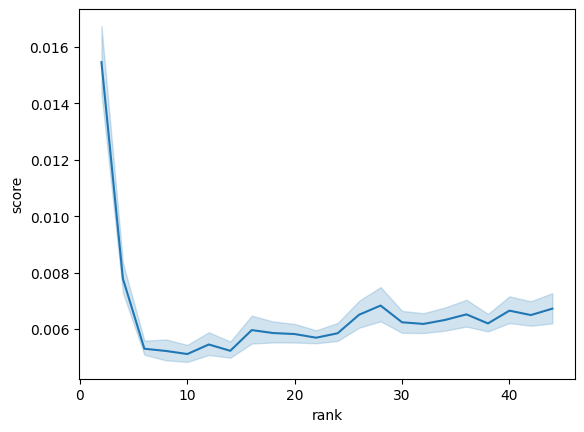

In [41]:
import matplotlib.pyplot as plt


cv = df.cv_results_

# print the best rank
print(df.best_params_)

sns.lineplot(data=cv, x="rank", y="score")
plt.show()

In [47]:
from experiments.things import compute_similarity_matrix_from_triplets, load_triplets
from utils.helpers import (
    estimate_effective_rank,
    compute_subsampling_fraction_symmetric,
)

train_triplets, val_triplets = load_triplets("../data/things")
sim = compute_similarity_matrix_from_triplets(1854, train_triplets)
sim = np.nan_to_num(sim, 0)  # replace nans with 0

In [48]:
cross_val_score(
    sim,
    observed_fraction=0.8,
    n_repeats=5,
    param_grid={"rank": np.arange(10, 80, 10), "max_outer": [15], "max_inner": [5]},
)

Running 35 jobs (7 params x 5 CV splits)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  3.1min finished
